<a href="https://colab.research.google.com/github/Poorya0071/Time_Series-/blob/main/Air_Quality_Index_of_Delhi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Quality Index of Delhi

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import tensorflow_hub as hub
from sklearn.preprocessing import MinMaxScaler

In [2]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/city_day.csv.zip", "r")
zip_ref.extractall()
zip_ref.close()

# Let's upload the dataset and change the time as the index ot timestamps 

In [3]:
data = pd.read_csv('/content/city_day.csv',parse_dates=["Date"], 
                 index_col=["Date"])
data.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Ahmedabad,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
2015-01-02,Ahmedabad,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2015-01-03,Ahmedabad,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
2015-01-04,Ahmedabad,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
2015-01-05,Ahmedabad,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29531 entries, 2015-01-01 to 2020-07-01
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   PM2.5       24933 non-null  float64
 2   PM10        18391 non-null  float64
 3   NO          25949 non-null  float64
 4   NO2         25946 non-null  float64
 5   NOx         25346 non-null  float64
 6   NH3         19203 non-null  float64
 7   CO          27472 non-null  float64
 8   SO2         25677 non-null  float64
 9   O3          25509 non-null  float64
 10  Benzene     23908 non-null  float64
 11  Toluene     21490 non-null  float64
 12  Xylene      11422 non-null  float64
 13  AQI         24850 non-null  float64
 14  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(2)
memory usage: 3.6+ MB


# We just need the data for Delhi, let's select it!

In [5]:
data.City.value_counts()

Ahmedabad             2009
Delhi                 2009
Mumbai                2009
Bengaluru             2009
Lucknow               2009
Chennai               2009
Hyderabad             2006
Patna                 1858
Gurugram              1679
Visakhapatnam         1462
Amritsar              1221
Jorapokhar            1169
Jaipur                1114
Thiruvananthapuram    1112
Amaravati              951
Brajrajnagar           938
Talcher                925
Kolkata                814
Guwahati               502
Coimbatore             386
Shillong               310
Chandigarh             304
Bhopal                 289
Ernakulam              162
Kochi                  162
Aizawl                 113
Name: City, dtype: int64

In [6]:
data_Delhi = data.loc[data['City']=='Delhi']
data_Delhi.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Delhi,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
2015-01-02,Delhi,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
2015-01-03,Delhi,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
2015-01-04,Delhi,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
2015-01-05,Delhi,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


In [7]:
data_Delhi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009 entries, 2015-01-01 to 2020-07-01
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        2009 non-null   object 
 1   PM2.5       2007 non-null   float64
 2   PM10        1932 non-null   float64
 3   NO          2007 non-null   float64
 4   NO2         2007 non-null   float64
 5   NOx         2009 non-null   float64
 6   NH3         2000 non-null   float64
 7   CO          2009 non-null   float64
 8   SO2         1899 non-null   float64
 9   O3          1925 non-null   float64
 10  Benzene     2009 non-null   float64
 11  Toluene     2009 non-null   float64
 12  Xylene      1228 non-null   float64
 13  AQI         1999 non-null   float64
 14  AQI_Bucket  1999 non-null   object 
dtypes: float64(13), object(2)
memory usage: 251.1+ KB


# Let's Drop some columns which are not so important!

In [8]:
data_Delhi.drop(['City', 'Xylene', 'AQI_Bucket'],axis = 1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
data_Delhi.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
Date,,,,,,,,,,,,
2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,472.0
2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,454.0
2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,143.0
2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,319.0
2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,325.0


# Fill the missing data by avarage values

In [10]:
df = data_Delhi.fillna(data_Delhi.mean())

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM2.5,2009.0,117.196153,82.871644,10.24,57.10,94.67,152.99,685.36
PM10,2009.0,232.809229,119.513475,18.59,138.81,220.56,307.38,796.88
NO,2009.0,38.985595,33.372824,3.57,15.90,27.25,50.72,221.03
NO2,2009.0,50.785182,22.685415,10.63,33.90,47.15,63.57,162.50
NOx,2009.0,58.567023,37.690350,0.00,31.15,52.75,75.36,254.80
NH3,2009.0,41.997150,17.262405,6.78,31.22,38.16,48.68,166.70
CO,2009.0,1.976053,2.560253,0.00,0.91,1.24,1.87,30.44
SO2,2009.0,15.901253,7.745483,2.34,10.46,14.97,19.36,71.56
O3,2009.0,51.323610,25.511388,6.94,34.08,45.45,59.88,257.73
Benzene,2009.0,3.544480,2.431232,0.00,1.87,2.96,4.68,20.64


# Univariate Time Series
We first start with univariate time series, define X and y, and split the dataset. It is essential to know that the dataset should not be shuffled for the time series forecasting.

In [12]:
timesteps = df.index.to_numpy()
AQI = df["AQI"].to_numpy()

In [13]:

# Create train and test splits the right way for time series data
split_size = int(0.8 * len(AQI)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], AQI[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], AQI[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1607, 402, 1607, 402)

In [14]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("AQI")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

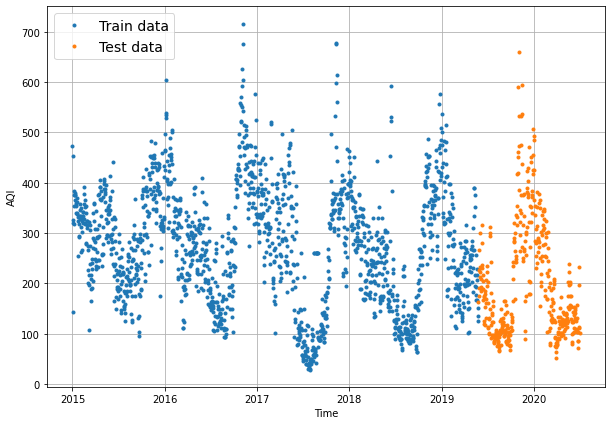

In [15]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Navie Forecasting

In [16]:
naive_forecast = y_test[:-1] 

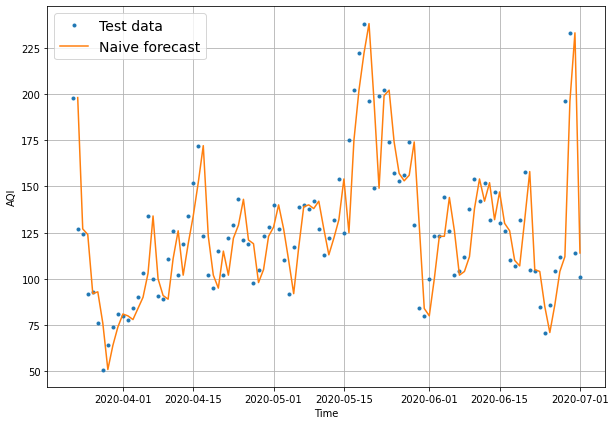

In [17]:

plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [18]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [19]:

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [20]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 31.471321,
 'mse': 2025.2968,
 'rmse': 45.003296,
 'mape': 16.582344,
 'mase': 0.9984556}

In [21]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 

In [22]:
def get_labelled_windows(x, horizon=1):

  return x[:, :-horizon], x[:, -horizon:]

In [23]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [24]:

full_windows, full_labels = make_windows(AQI, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2002, 2002)

In [25]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [472. 454. 143. 319. 325. 318. 353.] -> Label: [383.]
Window: [454. 143. 319. 325. 318. 353. 383.] -> Label: [375.]
Window: [143. 319. 325. 318. 353. 383. 375.] -> Label: [376.]


In [26]:

# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [27]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1601, 401, 1601, 401)

In [28]:
import os
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

#Simple Dense model

In [132]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/20))

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
history_1 = model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name),lr_schedule])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


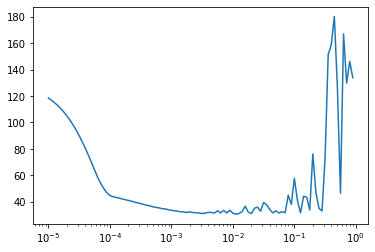

In [133]:
plt.semilogx(history_1.history['lr'], history_1.history['val_mae'])

In [134]:
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it


early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(lr = 0.01),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
history_1 = model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=500,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name),early_stopping])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [135]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

13/13 [==============================] - 0s 3ms/step - loss: 30.5764 - mae: 30.5764


[30.57640838623047, 30.57640838623047]

#Conv_2D model

In [33]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_conv1D")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_2.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [34]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_conv1D")
model_2.evaluate(test_windows, test_labels)

13/13 [==============================] - 0s 3ms/step - loss: 30.8191


30.819061279296875

# LSTM model

In [36]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(250, activation="relu")(x)
x = layers.Dense(1)(x)

 # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [37]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

13/13 [==============================] - 0s 4ms/step - loss: 30.7170


30.71700668334961

# Multivariate Forecasting

In [29]:
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df[f"AQI+{i+1}"] = df["AQI"].shift(periods=i+1)
df.head(10)

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7
Date,,,,,,,,,,,,,,,,,,,
2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,454.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,143.0,454.0,472.0,NaN,NaN,NaN,NaN,NaN
2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,319.0,143.0,454.0,472.0,NaN,NaN,NaN,NaN
2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,325.0,319.0,143.0,454.0,472.0,NaN,NaN,NaN
2015-01-06,149.58,252.10,17.21,37.84,42.46,134.97,9.44,3.66,26.83,3.63,7.35,318.0,325.0,319.0,143.0,454.0,472.0,NaN,NaN
2015-01-07,217.87,376.51,26.99,40.15,52.41,134.82,9.78,5.82,28.96,4.93,9.42,353.0,318.0,325.0,319.0,143.0,454.0,472.0,NaN
2015-01-08,229.90,360.95,23.34,43.16,51.21,138.13,11.01,3.31,30.51,5.80,11.40,383.0,353.0,318.0,325.0,319.0,143.0,454.0,472.0
2015-01-09,201.66,397.43,19.18,38.56,45.60,140.60,11.09,3.48,32.94,5.25,11.12,375.0,383.0,353.0,318.0,325.0,319.0,143.0,454.0


In [30]:
X = df.dropna().drop("AQI", axis=1).astype(np.float32) 
y = df.dropna()["AQI"].astype(np.float32)
X.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7
Date,,,,,,,,,,,,,,,,,,
2015-01-08,229.899994,360.950012,23.340000,43.160000,51.209999,138.130005,11.01,3.31,30.510000,5.80,11.40,353.0,318.0,325.0,319.0,143.0,454.0,472.0
2015-01-09,201.660004,397.429993,19.180000,38.560001,45.599998,140.600006,11.09,3.48,32.939999,5.25,11.12,383.0,353.0,318.0,325.0,319.0,143.0,454.0
2015-01-10,221.020004,361.739990,24.790001,46.389999,55.189999,134.059998,9.70,5.91,34.119999,4.87,9.44,375.0,383.0,353.0,318.0,325.0,319.0,143.0
2015-01-11,205.410004,393.200012,28.459999,47.290001,57.880001,131.100006,10.98,5.54,50.369999,5.93,10.59,376.0,375.0,383.0,353.0,318.0,325.0,319.0
2015-01-12,212.410004,345.630005,24.770000,44.709999,54.660000,148.509995,9.30,5.17,40.080002,6.20,10.68,379.0,376.0,375.0,383.0,353.0,318.0,325.0


In [31]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1601, 1601, 401, 401)

# Dense model

In [139]:

tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch/20))

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-6),
                metrics= ['mae'])

# Fit
history_6 = model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name), lr_schedule])

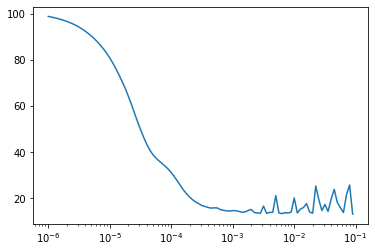

In [140]:
plt.semilogx(history_6.history['lr'], history_6.history['val_mae'])

In [141]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 50)


model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))

# Fit
model_6.fit(X_train, y_train,
            epochs=500,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name), early_stopping])

In [142]:

# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 12.8823


12.882347106933594

In [143]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

13/13 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([187.2047 , 201.75844, 227.37558, 270.42484, 278.15674, 249.49936,
       227.82582, 205.14912, 204.50658, 210.46825], dtype=float32)>

In [144]:

# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 12.882347,
 'mse': 343.29657,
 'rmse': 18.528265,
 'mape': 6.9177685,
 'mase': 0.4087039}

#LSTM model

In [145]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(18))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x)

 # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch/20))

model_7 = tf.keras.Model(inputs=inputs, outputs=output, name="model_7_lstm")

# Compile model
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-6),
                metrics = ['mae'])

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
history_7 = model_7.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_7.name),lr_schedule])

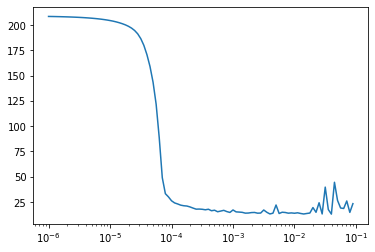

In [146]:
plt.semilogx(history_7.history['lr'], history_7.history['val_mae'])

In [32]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(18))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x)

 # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 50)


model_7 = tf.keras.Model(inputs=inputs, outputs=output, name="model_7_lstm")

# Compile model
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005),
                metrics = ['mae'])

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
history_7 = model_7.fit(X_train, y_train,
            epochs=500,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_7.name),early_stopping])

In [33]:
model_7 = tf.keras.models.load_model("model_experiments/model_7_lstm")
model_7.evaluate(X_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 12.7081 - mae: 12.7081


[12.708090782165527, 12.708090782165527]

In [34]:

def make_preds(model, input_data):

  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [35]:
model_7_preds = tf.squeeze(model_7.predict(X_test))
model_7_preds[:10]

13/13 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([187.53381, 200.94357, 230.58096, 273.58026, 280.6904 , 251.48643,
       233.6033 , 207.52693, 212.15356, 213.92809], dtype=float32)>

In [36]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 12.708093,
 'mse': 322.93686,
 'rmse': 17.970444,
 'mape': 6.936504,
 'mase': 0.40317553}

# Scale the data

In [50]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(18))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x)

 # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_7 = tf.keras.Model(inputs=inputs, outputs=output, name="model_7_lstm")

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/20)
)
# Compile model
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
                metrics = ['mae'])

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
history_7 = model_7.fit(X_train_scaled, y_train,
            epochs=100,
            batch_size=128,
            verbose=1, # only print 1 line per epoch
            validation_data=(X_test_scaled, y_test),
            callbacks=[create_model_checkpoint(model_name=model_7.name), lr_schedule])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 11s 777ms/step - loss: 274.0006 - mae: 274.0006 - val_loss: 200.1081 - val_mae: 200.1081 - lr: 1.0000e-05
Epoch 2/100
13/13 [==============================] - 6s 483ms/step - loss: 273.9991 - mae: 273.9991 - val_loss: 200.1068 - val_mae: 200.1068 - lr: 1.1220e-05
Epoch 3/100
13/13 [==============================] - 2s 205ms/step - loss: 273.9973 - mae: 273.9973 - val_loss: 200.1053 - val_mae: 200.1053 - lr: 1.2589e-05
Epoch 4/100
13/13 [==============================] - 2s 194ms/step - loss: 273.9954 - mae: 273.9954 - val_loss: 200.1036 - val_mae: 200.1036 - lr: 1.4125e-05
Epoch 5/100
13/13 [==============================] - 2s 196ms/step - loss: 273.9931 - mae: 273.9931 - val_loss: 200.1018 - val_mae: 200.1018 - lr: 1.5849e-05
Epoch 6/100
13/13 [==============================] - 2s 192ms/step - loss: 273.9906 - mae: 273.9906 - val_loss: 200.0996 - val_mae: 200.0996 - lr: 1.7783e-05
Epoch 7/100
13/13 [==============================] - 3s 212ms/s

In [62]:
pd.DataFrame(history_7.history)

,loss,mae,val_loss,val_mae,lr
0,274.000610,274.000610,200.108124,200.108124,0.000010
1,273.999054,273.999054,200.106796,200.106796,0.000011
2,273.997314,273.997314,200.105316,200.105316,0.000013
3,273.995361,273.995361,200.103622,200.103622,0.000014
4,273.993103,273.993103,200.101761,200.101761,0.000016
...,...,...,...,...,...
95,24.697905,24.697905,14.079776,14.079776,0.562341
96,29.218403,29.218403,23.189074,23.189074,0.630957
97,40.450638,40.450638,32.186855,32.186855,0.707946
98,30.941439,30.941439,16.907642,16.907642,0.794328


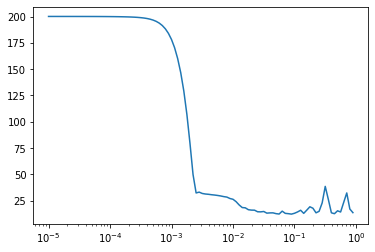

In [67]:
plt.semilogx(history_7.history['lr'], history_7.history['val_mae'])
# plt.axis([1e-5,1e-2, 0, 30])

In [69]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(18))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x)

 # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_7 = tf.keras.Model(inputs=inputs, outputs=output, name="model_7_lstm")

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 50)
# Compile model
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(lr = 51e-2),
                metrics = ['mae'])

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
history_7 = model_7.fit(X_train_scaled, y_train,
            epochs=500,
            batch_size=128,
            verbose=1, # only print 1 line per epoch
            validation_data=(X_test_scaled, y_test),
            callbacks=[create_model_checkpoint(model_name=model_7.name),early_stopping])

Epoch 1/500


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 4s 236ms/step - loss: 137.4464 - mae: 137.4464 - val_loss: 66.3352 - val_mae: 66.3352
Epoch 2/500
13/13 [==============================] - 3s 225ms/step - loss: 58.0010 - mae: 58.0010 - val_loss: 34.4395 - val_mae: 34.4395
Epoch 3/500
13/13 [==============================] - 2s 191ms/step - loss: 45.6055 - mae: 45.6055 - val_loss: 28.9536 - val_mae: 28.9536
Epoch 4/500
13/13 [==============================] - 2s 196ms/step - loss: 36.9049 - mae: 36.9049 - val_loss: 19.3732 - val_mae: 19.3732
Epoch 5/500
13/13 [==============================] - 2s 199ms/step - loss: 32.0995 - mae: 32.0995 - val_loss: 18.0321 - val_mae: 18.0321
Epoch 6/500
13/13 [==============================] - 2s 205ms/step - loss: 27.9304 - mae: 27.9304 - val_loss: 17.1721 - val_mae: 17.1721
Epoch 7/500
13/13 [==============================] - 0s 11ms/step - loss: 26.7635 - mae: 26.7635 - val_loss: 26.2721 - val_mae: 26.2721
Epoch 8/500
13/13 [==============================] -

In [72]:
model_7 = tf.keras.models.load_model("model_experiments/model_7_lstm")
model_7.evaluate(X_test_scaled, y_test)

13/13 [==============================] - 1s 6ms/step - loss: 11.0448 - mae: 11.0448


[11.044829368591309, 11.044829368591309]

In [73]:
model_7_preds = tf.squeeze(model_7.predict(X_test_scaled))
model_7_preds[:10]

13/13 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([166.7996 , 191.6048 , 221.7005 , 268.10593, 272.36905, 235.58696,
       217.13298, 183.54239, 199.48102, 206.39825], dtype=float32)>

In [74]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 11.044829,
 'mse': 251.43086,
 'rmse': 15.856571,
 'mape': 5.898555,
 'mase': 0.350407}

In [77]:
pd.DataFrame(history_7.history)

,loss,mae,val_loss,val_mae
0,137.446365,137.446365,66.335228,66.335228
1,58.000977,58.000977,34.439507,34.439507
2,45.605511,45.605511,28.953581,28.953581
3,36.904873,36.904873,19.373247,19.373247
4,32.099453,32.099453,18.032148,18.032148
...,...,...,...,...
125,17.419897,17.419897,12.794602,12.794602
126,17.393320,17.393320,12.298950,12.298950
127,17.347933,17.347933,12.719708,12.719708
128,17.312754,17.312754,12.090631,12.090631


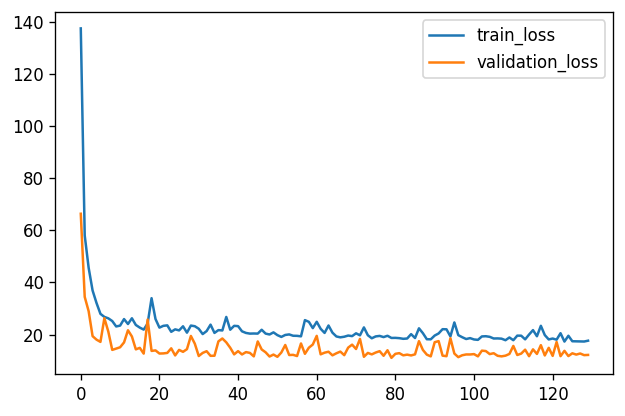

In [82]:
plt.figure(dpi = 120)
plt.plot(history_7.history['loss'], label = 'train_loss')
plt.plot(history_7.history['val_loss'], label = 'validation_loss')
plt.legend()

# Conclusion

The best model is the multivariate LSTM with the scaled data and using a learning rate scheduler, model checkpoint, and early stopping callbacks.